In [34]:
import numpy as np
from itertools import combinations
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import sys
sys.path.append('../scores')
from interactions import *
from pdpbox import pdp
import pandas as pd
from scipy.stats import random_correlation
from copy import deepcopy
from os.path import join as oj
from tqdm import tqdm
import pickle as pkl
import seaborn as sns
out_dir = 'sim_results'

# generate data

In [16]:
def generate_y(X):
    y = np.power(np.pi, X[:, 0] * X[:, 1]) * np.sqrt(2 * np.abs(X[:, 2])) - np.arcsin(.5 * X[:, 3])
    y += np.log(np.abs(X[:, 2] + X[:, 4]) + 1) + X[:, 8]/(1 + np.abs(X[:, 9])) * np.sqrt(np.abs(X[:, 6])/(np.abs(X[:, 7]) + 1))
    y -= X[:, 1] * X[:, 6]
    return y

seed = 1
np.random.seed(seed)


# get and X and Y with certain means
means = np.zeros(10)
inv_sum = 10
eigs = []
while(len(eigs) <= 8):
    eig = np.random.uniform(0, inv_sum)
    eigs.append(eig)
    inv_sum -= eig
eigs.append(10 - np.sum(eigs))
covs = random_correlation.rvs(eigs)
covs = random_correlation.rvs(eigs)
X = np.random.multivariate_normal(means, covs, (70000,))
no_outliers = np.logical_and(np.all(X <= 2, axis=1), np.all(X >= -2, axis=1))
print(np.count_nonzero(no_outliers))
X = X[no_outliers]
y = generate_y(X)

mask = np.isnan(y)
print(mask)
X = X[~mask]
y = y[~mask]

# put X into a dataframe
feats = ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", "x10"]
df = pd.DataFrame(X, columns=feats)

54286
[False False False ... False False False]


**generate test data**

In [ ]:
X_test = np.random.multivariate_normal(means, covs, (1000000,))
no_outliers = np.logical_and(np.all(X_test <= 2, axis=1), np.all(X_test >= -2, axis=1))
print(np.count_nonzero(no_outliers))
X_test = X_test[no_outliers]
y_test = generate_y(X_test)
mask = np.isnan(y_test)
X_test = X_test[~mask]
y_test = y_test[~mask]

**generate data with covariance**

In [15]:
X_cond = np.random.multivariate_normal(means, covs, (15000000,))
no_outliers = np.logical_and(np.all(X_cond <= 2, axis=1), np.all(X_cond >= -2, axis=1))
print(np.count_nonzero(no_outliers))
X_cond = X_cond[no_outliers]
y_cond = generate_y(X_cond)
mask_cond = np.isnan(y_cond)
X_cond = X_cond[~mask_cond]
y_cond = y_cond[~mask_cond]

11601426


# fit a model

In [9]:
forest = RandomForestRegressor(n_estimators=50)
forest.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [10]:
preds = forest.predict(X_test)
print("MSE", np.mean((y_test-preds) ** 2))
print(min(y_test), max(y_test), np.mean(y_test))

773469
MSE 0.5686663502728034
-4.275466148563239 168.36365466389717 2.198546387634916


# compute and compare 1d curves

In [ ]:
curves = {}
for i in tqdm(range(10)): #range(3, 10):
    curves_i = {}
    S = np.zeros(10)
    S[i] = 1
    exp = conditional1D(X_cond, y_cond, S, np.arange(-1, 1, .01), .01)
#     exp_name = "F2_Corr/exp_" + feats[i] + ".csv"
#     np.savetxt(exp_name, exp, delimiter=",")
    curves_i['exp'] = exp
    print("conditional expectation complete")
    curve = make_curve_forest(forest, X, y, S, (-1, 1), .01, C = 1, continuous_y = True)
#     curve_name = "F2_Corr/curve_" + feats[i] + ".csv"
#     np.savetxt(curve_name, curve, delimiter=",")
    curves_i['dac'] = curve
    print("DAC curve complete")
    pdp_xi = pdp.pdp_isolate(model=forest, dataset=df, model_features=feats, feature=feats[i], num_grid_points=200).pdp
#     pdp_name = "F2_Corr/pdp_" + feats[i] + ".csv"
#     np.savetxt(pdp_name, pdp_xi, delimiter=",")
    curves_i['pdp'] = pdp_xi
    print("PDP curve complete")
    print("row " + str(i) + " complete")
    curves[i] = deepcopy(curves_i)
print("complete!")
# pkl.dump(curves, open(oj(out_dir, 'curves_1d.pkl'), 'wb'))

# analyze curves

**load and calculate stats**

In [39]:
curves = pkl.load(open(oj(out_dir, 'curves_1d.pkl'), "rb"))

print("MSE comparison 1D")
count = 0
mse_dac, mse_pdp = [], []
corr_dac, corr_pdp = [], []
num_vars = 10
for i in range(num_vars):
    curves_i = curves[i]
    exp = curves_i['exp']
    dac = curves_i['dac']
    pdp_xi = curves_i['pdp']
    mse_dac.append(np.mean((exp - dac) ** 2))
    mse_pdp.append(np.mean((exp - pdp_xi) ** 2))
    corr_dac.append(np.corrcoef(dac, exp)[0, 1])
    corr_pdp.append(np.corrcoef(pdp_xi, exp)[0, 1])

**plot results**

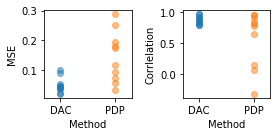

In [57]:
plt.figure(figsize=(4, 2))
R, C = 1, 2
plt.subplot(R, C, 1)
plt.plot([0] * num_vars, mse_dac, 'o', alpha=0.5)
plt.plot([1] * num_vars, mse_pdp, 'o', alpha=0.5)
plt.ylabel('MSE')
plt.xticks([0, 1], ['DAC', 'PDP'])
plt.xlim((-0.3, 1.3))
plt.xlabel('Method')


plt.subplot(R, C, 2)
plt.plot([0] * num_vars, corr_dac, 'o', alpha=0.5)
plt.plot([1] * num_vars, corr_pdp, 'o', alpha=0.5)
plt.ylabel('Corrlelation')
plt.xticks([0, 1], ['DAC', 'PDP'])
plt.xlim((-0.3, 1.3))
plt.xlabel('Method')

plt.tight_layout()
plt.savefig('sim_figs/mse.pdf')
plt.show()